In [32]:
import numpy as np
from random import sample
import time
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
#from statsmodels.tsa.api import VARMAX, VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ

pd.set_option('display.max_columns', None)
plt.rcParams["figure.figsize"] = (20,7)

## Utils functions

In [2]:
def mean_norm(df_input):
    """
    returns a dataframe with all columns normalized
    """
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

def evaluate_stationnarity(df, column):
    """
    For a specified series (column of the dataset df), returns the p-value of ADF test
    to assess the stationarity of the series
    """
    p_value = adfuller(df[column])[1]
    return p_value

def is_stationnary(df, column):
    """
    returns a Boolean True if df[column] is stationary, False if not
    """
    if evaluate_stationnarity(df, column) <= .5:
        is_stationnary =  True
    else:
        is_stationnary = False
    return is_stationnary

def set_index_date(df):
    df[["year", "month"]] = df["date"].str.split(':', expand=True)
    df["day"] = 1
    df = create_date_column(df)
    return df

def create_date_column(df):
    """
    takes dataframe with columns year, month, day
    returns dataframe with column dates as timestamp
    """

    dates_df = df[['year', 'month', 'day']]
    df['date'] = pd.to_datetime(dates_df)
    df = df.drop(['year', 'month', 'day'], axis=1)
    df = df.set_index('date')
    return df

In [3]:
dict_months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 
               'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

macro_variables = {
    "RPI": "Real Personal Income",
    "INDPRO": "Industrial Production Index",
    "CAPUTLB00004S": "Capacity utilization: manufacturing",
    "HWIURATIO": "Help wanted to unemployed ratio",
    "UNRATE": "Unemployment rate",
    "PAYEMS": "All employees: total nonfarm ",
    "CES0600000007": "Weekly hours: goods-producing",
    "CES0600000008": "Avg. hourly earnings, goods-producing",
    "HOUST": "Housing starts",
    "PERMIT": "Housing permits",
    "DPCERA3M086SBEA": "Real consumer spending",
    "CMRMTSPLx": "Real manuf. and trade sales",
    "NAPMNOI": "ISM: new orders index",
    "AMDMNOx": "Orders for durable goods ",
    "FEDFUNDS": "Federal funds rate",
    "PPIFGS": "PPI, finished goods",
    "PPICMM": "PPI, commodities",
    "PCEPI": "PCE price index",
}

finance_variables = {
    "SP500": "S&P 500 ",
    "BAAT10Y": "10 year BAA",
    "excessreturn": "Excess Return",
    "SMB": "SMB",
    "HML": "HML",
    "aggind1": "Consumer",
    "aggind2": "Manufactory",
    "aggind3": "High Technology",
    "aggind4": "Health",
    "aggind5": "Other",
    "momentum": "momentum",
    "R15_R11": "R15_R11"
}

full_dict_variables = {}
full_dict_variables.update(macro_variables)
full_dict_variables.update(finance_variables)

Below function to get the index as time values, monthly

In [4]:
def process_initial_data(df):
        df["month"] = df["Date"].astype(str).str[:3]
        df["year"] = df["Date"].astype(str).str[3:]
        df["month"] = df["month"].replace(dict_months)
        df["day"] = 1
        df = create_date_column(df)
        df = df.drop(["Date"], axis=1)

        for column in df.columns:
            df[column] = df[column].astype("float")
        return df

In [5]:
path_full_data = "datasets/from Audin/dataverse_files/Matlabimplementation/data.csv"
full_data = pd.read_csv(path_full_data)
full_data = process_initial_data(full_data)

In [6]:
full_data.head()

,PAYEMS,INDPRO,CAPUTLB00004S,HWIURATIO,UNRATE,RPI,CES0600000007,HOUST,PERMIT,DPCERA3M086SBEA,CMRMTSPLx,NAPMNOI,AMDMNOx,CES0600000008,PPIFGS,PPICMM,PCEPI,FEDFUNDS,SP500,BAAT10Y,excessreturn,SMB,HML,momentum,R15_R11,aggind1,aggind2,aggind3,aggind4,aggind5
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960-01-01,54274.0,24.1298,85.5616,1.134163,5.2,2391.2,40.0,1460.0,1092.0,18.910,262790.7884,65.4,14584.80867,2.22,33.1,34.2,17.410,3.99,58.03,0.62,-6.98,2.05,2.69,-3.49,5.34,-7.56,-7.09,-5.49,-6.35,-4.42
1960-02-01,54513.0,23.9151,84.6108,1.231601,4.8,2392.8,39.7,1503.0,1088.0,18.993,266654.5376,52.5,14535.90107,2.23,33.1,34.3,17.427,3.97,55.78,0.85,1.17,0.56,-2.03,3.86,3.09,1.01,-0.09,6.67,0.27,0.01
1960-03-01,54458.0,23.7004,83.2421,1.046699,5.4,2397.2,39.5,1109.0,955.0,19.262,259356.2002,52.2,14375.07033,2.24,33.4,34.2,17.437,3.84,55.02,1.00,-1.63,-0.47,-2.84,1.43,0.00,-2.65,-1.90,0.95,1.61,-2.33
1960-04-01,54812.0,23.5125,82.2593,1.049724,5.2,2405.6,39.8,1289.0,1016.0,19.560,261773.3221,52.0,14220.82331,2.24,33.4,34.1,17.501,3.92,55.73,0.92,-1.71,0.39,-2.37,2.81,2.57,-0.41,-2.77,-0.14,1.68,-1.11
1960-05-01,54473.0,23.4857,81.4711,1.064724,5.1,2411.7,39.7,1271.0,1052.0,19.166,253674.9631,45.8,14392.94042,2.24,33.4,34.1,17.519,3.85,55.22,0.93,3.12,1.27,-3.72,4.81,6.73,2.83,1.62,6.89,13.77,0.34


## Processing and formatting of data

## Uniformisation and de-trending of data

## Processing of volatility

The data processing is handled by the below class Data
The data, with a proper time index, is first put as log and then de trended (when necessary, i.e. when original data
is not already stationnary, based on AD Fuller test
The data is then normalized and the volatility is computed as a lag variation over the past 12 months

In [7]:
class Data:
    def __init__(self, data, dict_variables):
        self.data = data
        self.dict_variables = dict_variables
    
    def stationnarize(self):
        df_log = pd.DataFrame()
        df_log_shift = pd.DataFrame()
        df_stationnary = pd.DataFrame()

        for column in self.data.columns:
            if is_stationnary(self.data, column) == False:  # Series that are not stationnary are de-trended
                # log value of the series is calculated, before it is shifted with a lag 1
                df_log[column] = np.log(self.data[column])
                df_stationnary[column] = df_log[[column]] - df_log[[column]].shift()
            else:
                df_stationnary[column] = self.data[column]
        self.stationnary_data = df_stationnary
        
    def uniformize(self):
        self.df_uniform_stat = mean_norm(self.stationnary_data).dropna()

    def process_volatility(self):
        window = 12  # trading days in rolling window
        dpy = 12  # trading days per year
        ann_factor = dpy / window
        df_volatility = pd.DataFrame()
        for column in self.df_uniform_stat.columns:
            df_volatility[column] = self.df_uniform_stat[column].rolling(window).var() * ann_factor
        df_volatility = df_volatility.rename(columns=self.dict_variables)
        df_volatility = pd.DataFrame(df_volatility.values, columns=df_volatility.columns, index=df_volatility.index.values)
        self.df_volatility = df_volatility
        
    def get_volatility(self):
        self.stationnarize()
        self.uniformize()
        self.process_volatility()
        

In [8]:
data = Data(full_data, full_dict_variables)
data.get_volatility()

Below, the volatility is displayed for each variable 

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

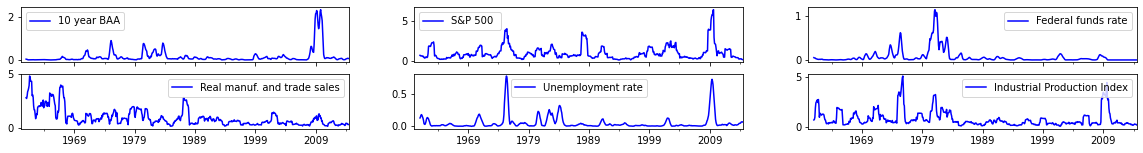

In [9]:
data.df_volatility[["10 year BAA", "S&P 500 ", "Federal funds rate", "Real manuf. and trade sales",
 "Unemployment rate", "Industrial Production Index"]].plot(subplots=True, layout=(10, 3),  figsize=(20, 12), color="blue")

## Factor Model

In [10]:
factors = dict()
for macro_variable in list(macro_variables.values()):
    factors[macro_variable] = ["Macro"]
for finance_variable in list(finance_variables.values()):
    factors[finance_variable] = ["Finance"]

#### Implementation and fitting of Factor Model

Model with 2 factors: Macro and Finance -  Idiosyncratic volatilities are supposed i.i.d.

The Factor Model process is handled by the below class FactorModel.
The idiosyncratic components are taken as AR(1) process
Two common factors are created, Macro and Finance

In [11]:
class FactorModel:
    def __init__(self, data, factors):
        self.data = data
        self.factors = factors
        self.factor_model = DynamicFactorMQ(self.data,
                                            factors=self.factors,
                                            factor_orders = {'Macro': 1, "Finance": 1},
                                            idiosyncratic_ar1=True,
                                            standardize=False)
        
    def fit(self):
        self.model_results = self.factor_model.fit(disp=30)
        
    def get_factors(self):
        self.df_factors = np.sqrt(-self.model_results.factors.smoothed)
        
    def plot_factors(self):
        self.df_factors.plot(figsize=(16, 6), subplots=True, color="blue")
        
    def get_correlation_factors(self):
        return np.round(np.corrcoef(self.df_factors["Macro"], self.df_factors["Finance"])[1, 0], 2)
    
    def get_reduced_idiosyncratic(self, list_variables):
        plt.rcParams["figure.figsize"] = (30,4)
        display_horizontal = 2
        n = len(list_variables)
        display_vertical = int(n/3) + n%3
        fig, axs = plt.subplots(display_vertical, display_horizontal)
        fig.suptitle('Reduced form and idiosyncratic component')
        fig.set_figheight(12 * display_horizontal)
        fig.set_figwidth(20)
        for i in range(display_vertical):
            for j in range(display_horizontal):
                variable = list_variables[display_horizontal*i+j]
                axs[i, j].plot(self.model_results.fittedvalues[variable], label="Reduced form", color="black")
                axs[i, j].plot(np.abs(self.model_results.resid[variable]), label="idiosyncratic component", color="r", linestyle="--")
                axs[i, j].set_title(variable)
                axs[i, j].legend()

        plt.legend()
        fig.tight_layout()
            
    def get_pca_idiosyncratics(self, nb_components):
        pca_idiosyncratics = PCA(n_components=nb_components)
        pca_idiosyncratics.fit(self.model_results.resid.dropna())
        return np.round(pca_idiosyncratics.explained_variance_ratio_[0], 2)

In [12]:
factor_model = FactorModel(data.df_volatility, factors)

/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [13]:
factor_model.fit()
factor_model.get_factors()

EM start iterations, llf=9849
EM iteration 30, llf=10315, convergence criterion=6.3366e-06
EM iteration 60, llf=10316, convergence criterion=1.9108e-06
EM converged at iteration 88, llf=10316, convergence criterion=9.9722e-07 < tolerance=1e-06


We display below the uncertainty factors for Macro and Finance

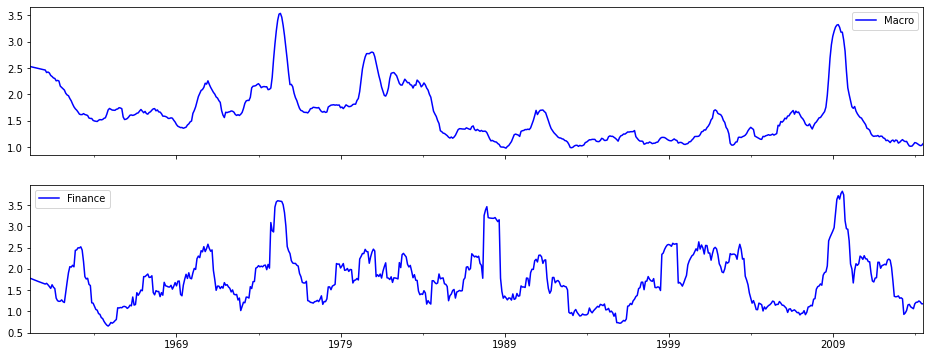

In [14]:
factor_model.plot_factors()

We compute to correlation (co-movement) between these two uncertainty factors

In [15]:
factor_model.get_correlation_factors()

0.43

The estimated macro and financial uncertainties displayed above have some tendency to co-move, with a correlation of 0.43

Below we compare, for a set of variables, the reduced for and their idiosyncratic component, to observe how much of the information is caputed by the model

In [16]:
sample(list(full_dict_variables.values()), 4)

['Real Personal Income',
 'Excess Return',
 'Industrial Production Index',
 'Weekly hours: goods-producing']

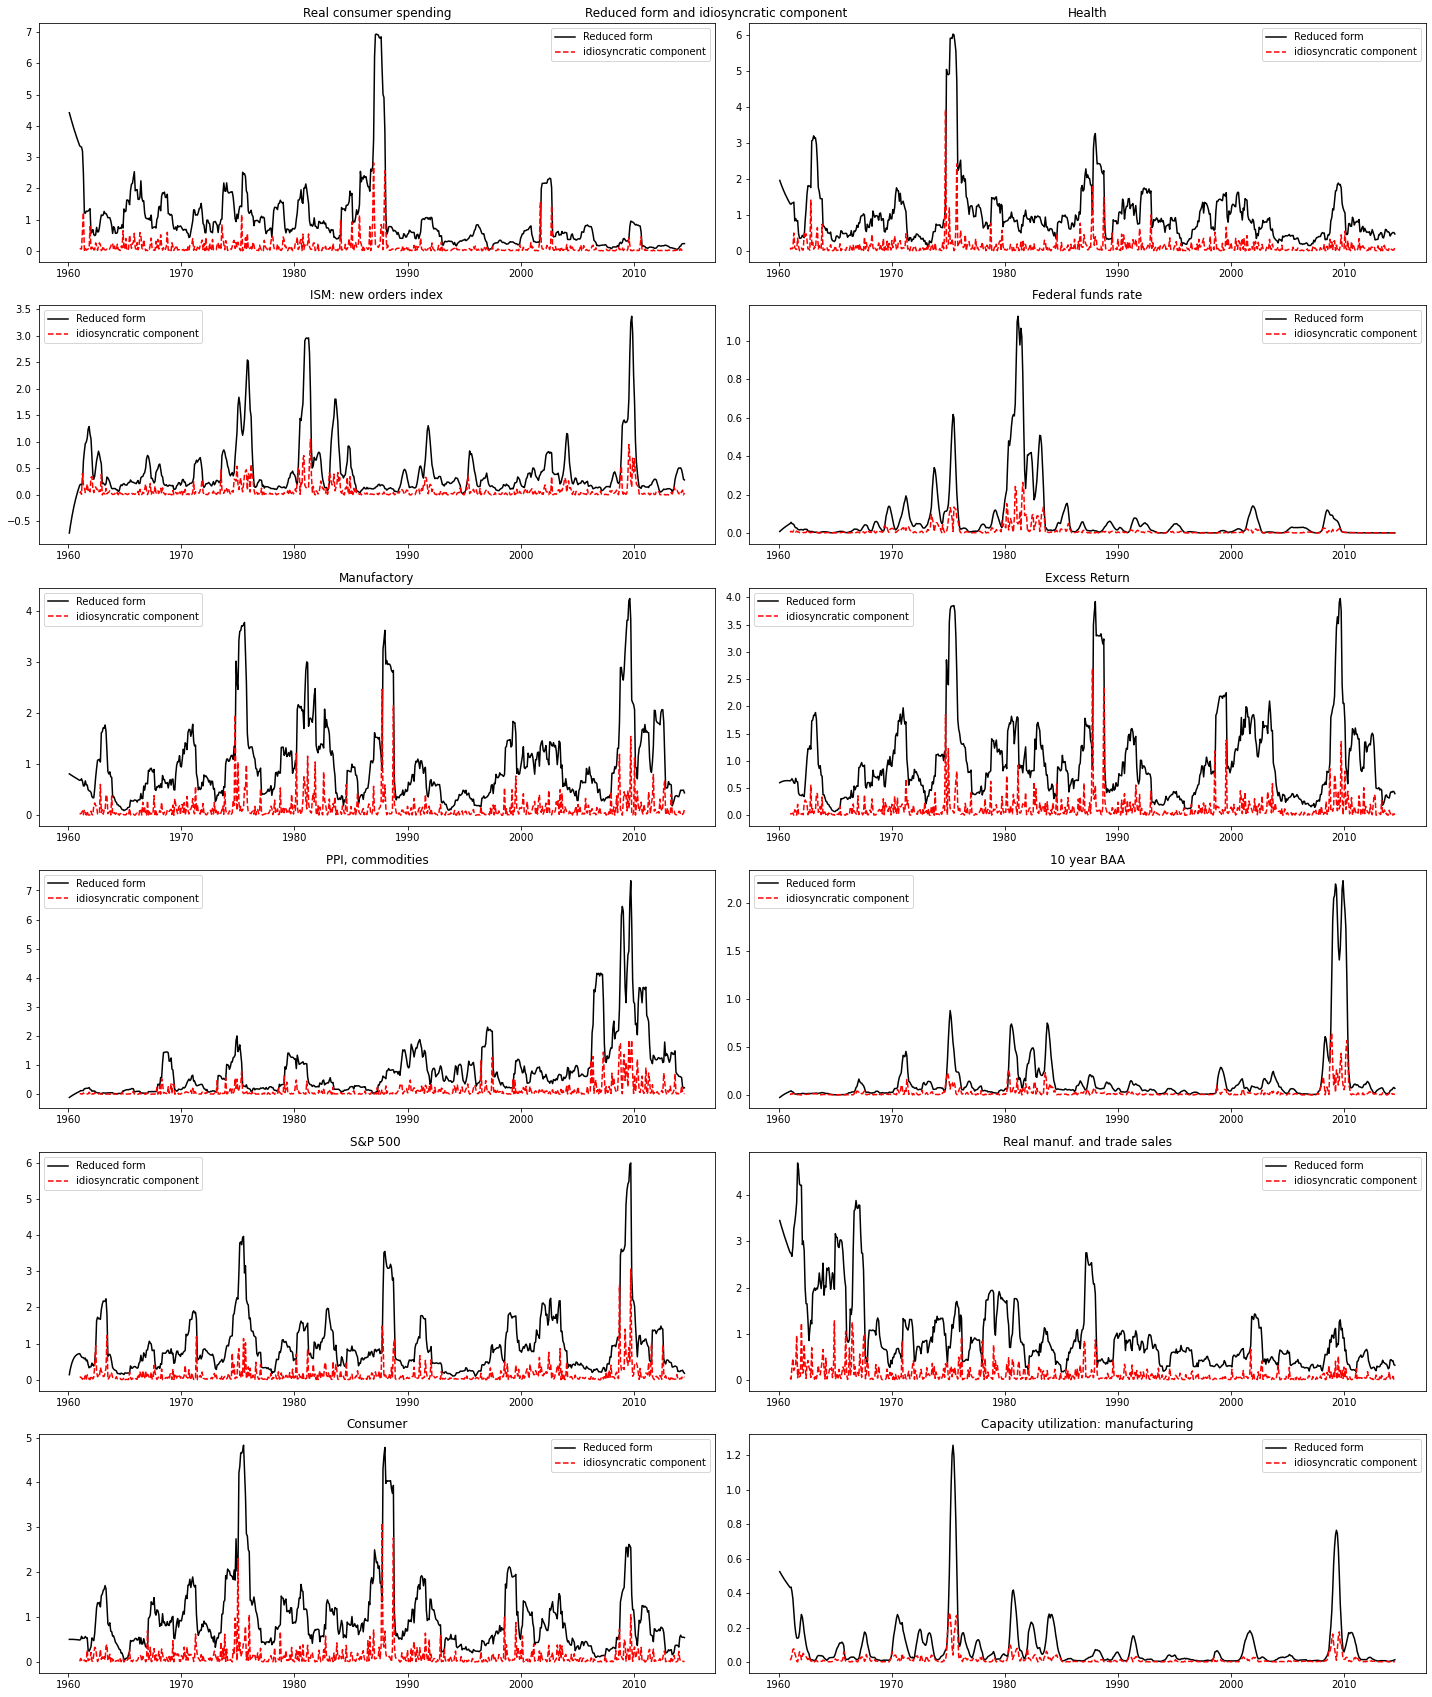

In [17]:
factor_model.get_reduced_idiosyncratic(sample(list(full_dict_variables.values()), 14))

In [18]:
factor_model.get_pca_idiosyncratics(nb_components=1)

0.22

The PCA on the idiosynctratic components shows shows a first component of 22%. This is slightly higher than proposed in the article, but notheless shows the absence of a sizable residual factor structure in the idiosynctratic volatilities.

## VAR model on common component

In [23]:
VAR_data.head()

,Macro,Finance,All employees: total nonfarm,Industrial Production Index,Capacity utilization: manufacturing,Help wanted to unemployed ratio,Unemployment rate,Real Personal Income,Weekly hours: goods-producing,Housing starts,Housing permits,Real consumer spending,Real manuf. and trade sales,ISM: new orders index,Orders for durable goods,"Avg. hourly earnings, goods-producing","PPI, finished goods","PPI, commodities",PCE price index,Federal funds rate,S&P 500,10 year BAA,Excess Return,SMB,HML,momentum,R15_R11,Consumer,Manufactory,High Technology,Health,Other
1961-01-01,2.461330,1.642551,2.405525,0.690073,0.442327,0.121056,0.127716,0.488474,0.649664,0.086819,0.010611,3.416150,2.799024,0.149370,0.923829,0.879209,0.485926,0.111088,0.218543,0.052978,0.660813,0.038912,0.648923,0.216567,0.728665,0.317364,3.175742,0.503959,0.700596,0.709413,1.343145,0.552622
1961-02-01,2.414020,1.659642,1.849851,0.737892,0.416018,0.102212,0.143197,0.508819,0.609323,0.042945,0.005348,3.402591,2.730853,0.137425,0.988114,0.832017,0.487847,0.107285,0.218696,0.046763,0.600693,0.030060,0.675829,0.376604,0.696623,0.284476,3.142611,0.578200,0.725731,0.639403,1.374777,0.607501
1961-03-01,2.424571,1.625382,2.053964,0.957660,0.371447,0.103285,0.170179,0.524068,0.597346,0.041194,0.004999,3.265958,2.949526,0.174996,0.989163,0.755500,0.348237,0.113260,0.260719,0.043684,0.586244,0.027465,0.642427,0.465452,0.618129,0.326955,3.257791,0.528875,0.672613,0.666495,1.383649,0.559833
1961-04-01,2.406223,1.585526,0.874747,1.894589,0.293839,0.094273,0.178672,0.514754,0.519395,0.040395,0.004630,2.526291,3.349504,0.624054,1.216404,1.219188,0.459038,0.118604,0.197334,0.041204,0.598061,0.017058,0.598088,0.465459,0.591111,0.339535,3.222081,0.536886,0.578084,0.657965,1.405298,0.534118
1961-05-01,2.359090,1.540501,0.813112,2.387026,0.215181,0.069588,0.165697,0.614104,0.455521,0.038739,0.003065,1.238661,3.484601,0.826454,1.216628,1.231641,0.482688,0.178848,0.197961,0.029107,0.559604,0.005808,0.591490,0.482543,0.391083,0.312545,3.190104,0.538763,0.583483,0.581913,0.859146,0.531960


In [43]:
VAR_data = factor_model.df_factors["1961-01-01":].join(data.df_volatility.dropna())
VAR_train = VAR_data[:"2012-01-01"]
VAR_test = VAR_data["2012-01-01":]

The VAR model is processed by the below class VARModel

In [64]:
class VARModel:
    def __init__(self, train, test):
        self.data = data
        self.model = VARMAX(endog=train)
        
    def fit(self):
        self.model_results = self.model.fit(maxiter=60)
        
    def plot_impulse_responses(self, variable):
        if variable=="Macro":
            impulse = 0
        elif variable=="Finance":
            impulse = 1
        else:
            print("Not accepted variable")
        self.model_results.impulse_responses(50,orthogonalized=True, impulse=impulse).plot(subplots=True,
                                                                                           layout=(12, 3),
                                                                                           figsize=(16, 16),
                                                                                           color="blue")
    
    def forecast(self):
        self.forecast = self.model_results.forecast(steps=len(VAR_test))
        
    def plot_forecast(self, variable):
        plt.plot(VAR_train[variable]["2000-01-01":], color="blue")
        plt.plot(VAR_test[variable], label=f"Real {variable}", color="blue", linestyle="--")
        plt.plot(forecast[variable], label="forecast", color="r", linestyle="--")
        plt.legend()


In [65]:
VAR_model = VARModel(VAR_train, VAR_test)
VAR_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1584     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.92125D+01    |proj g|=  1.80160D+01


 This problem is unconstrained.



At iterate    5    f= -2.92162D+01    |proj g|=  8.58702D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 1584      8     10      1     0     0   7.046D+00  -2.922D+01
  F =  -29.217754317481774     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


/Users/victorgraff/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We display below the impulse responses of each variable to a shock on Marco and Finance

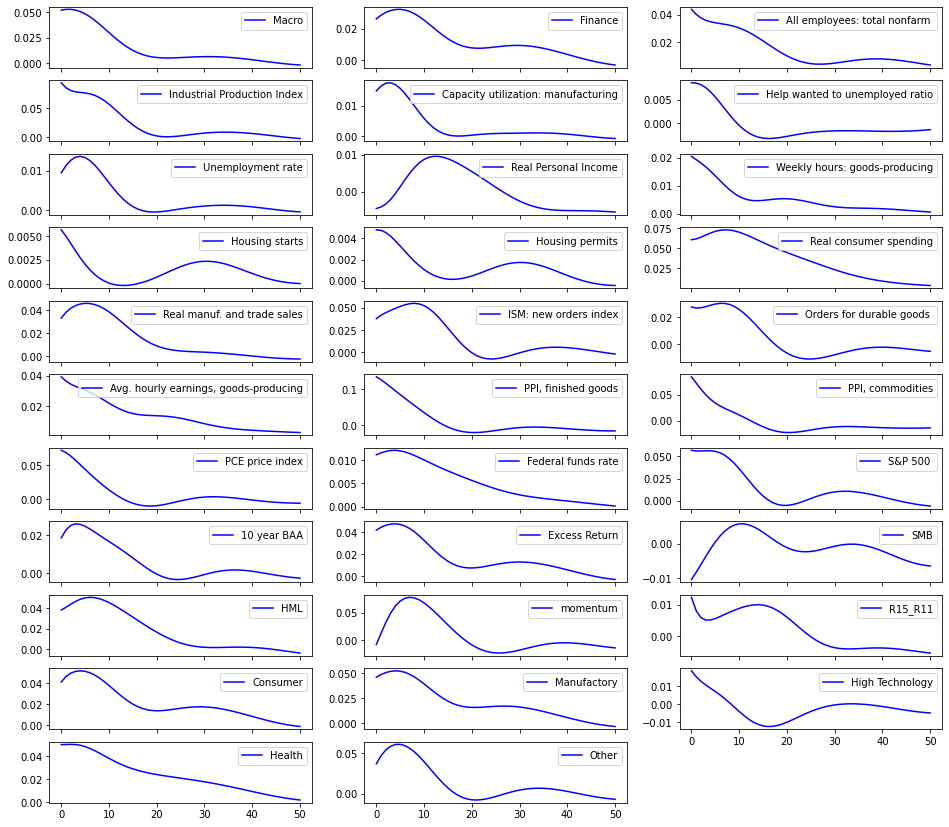

In [66]:
VAR_model.plot_impulse_responses(variable="Macro")

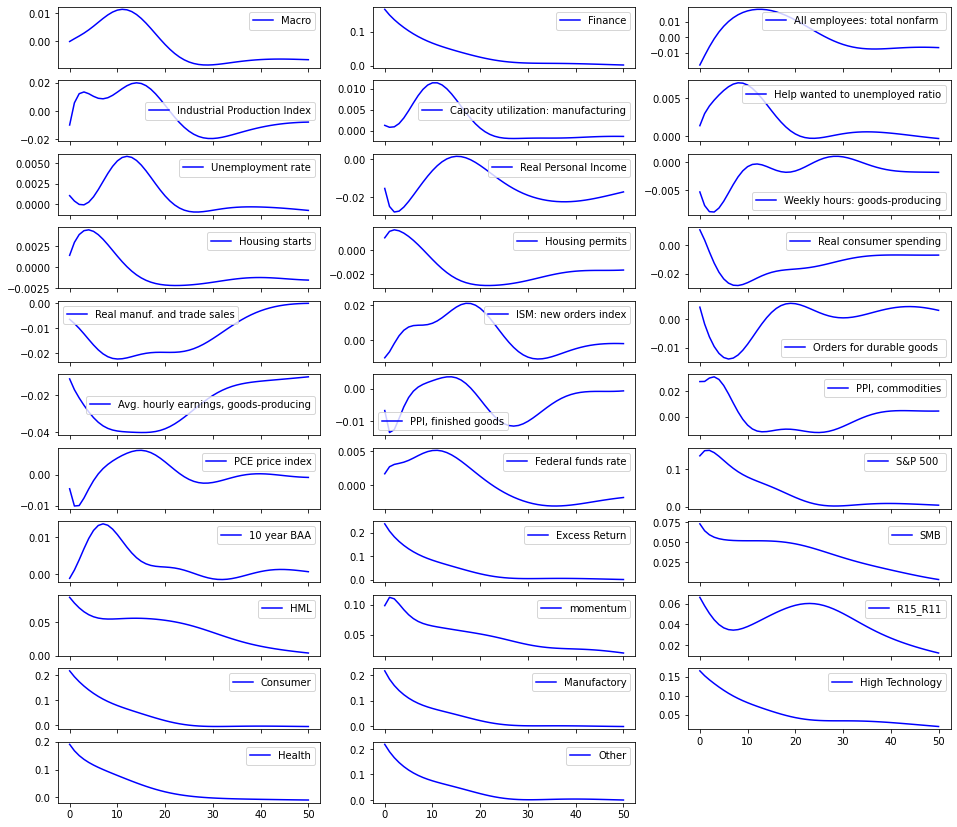

In [67]:
VAR_model.plot_impulse_responses(variable="Finance")

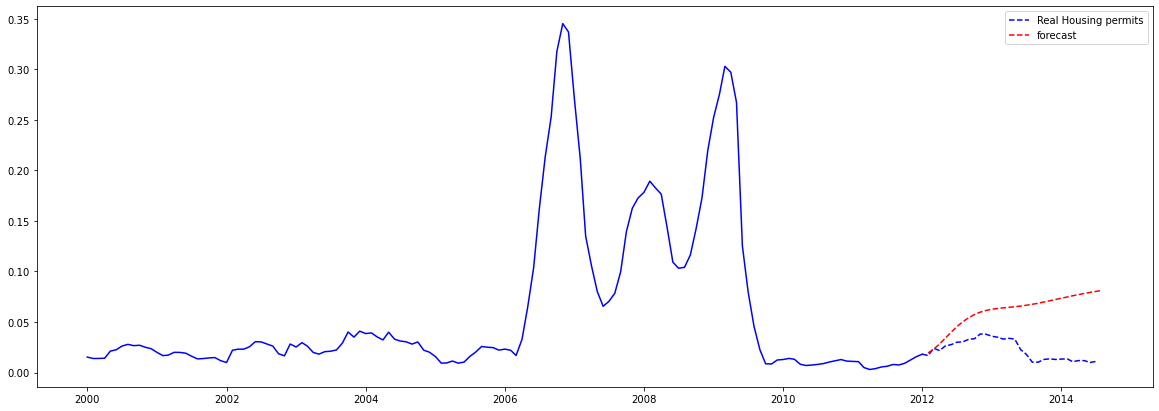

In [68]:
VAR_model.forecast()
VAR_model.plot_forecast("Housing permits")